In [9]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/input/brain-tumor-noise/all'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.metrics import accuracy_score

In [7]:
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

In [8]:
X_train = []
Y_train = []
image_size = 150
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
for i in labels:
    folderPath = os.path.join('../input/noisy-data-set/all/noise/training',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/noisy-data-set/all/noise/testing',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../input/brain-tumor-noise/empty/noise/training\\glioma_tumor'

In [13]:
X_train,Y_train = shuffle(X_train,Y_train,random_state=101)
X_train.shape

(3264, 150, 150, 3)

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X_train,Y_train,test_size=0.1,random_state=101)

In [15]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train=y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test=y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

Convolutional Neural Network

In [16]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation = 'relu',input_shape=(150,150,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(4,activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 69, 69, 64)        0

In [18]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [3]:
history = model.fit(X_train,y_train,epochs=20,validation_split=0.1)

NameError: name 'model' is not defined

In [20]:
# ACCURACY

# Evaluate the model on the test set
accuracy = model.evaluate(X_test, y_test, verbose=2)

# Print the accuracy
print(f"Test Accuracy: {accuracy[1]*100:.2f}%")

11/11 - 6s - loss: 0.8508 - accuracy: 0.7003
Test Accuracy: 70.03%


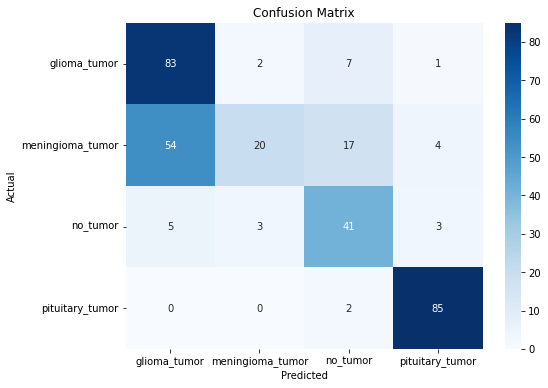

In [24]:
# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict class probabilities for test set
y_pred_probs = model.predict(X_test)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
# print("Confusion Matrix:")
# print(cm)

# Get class labels
class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Plot confusion matrix as a table
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

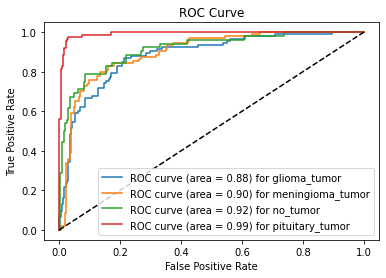

In [25]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])  # Use y_pred_probs instead of y_pred
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {labels[i]}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [26]:
# F1-SCORE

from sklearn.metrics import f1_score

# Calculate F1-score
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='weighted')
print(f"F1-score: {f1:.2f}")

F1-score: 0.66


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
model.save('braintumor.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

NameError: name 'model' is not defined

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

Prediction

In [ ]:
img = cv2.imread('../input/brain-tumor-classification-mri/Training/pituitary_tumor/p (107).jpg')
img = cv2.resize(img,(150,150))
img_array = np.array(img)
img_array.shape

In [ ]:
img_array = img_array.reshape(1,150,150,3)
img_array.shape

In [ ]:
from tensorflow.keras.preprocessing import image
img = image.load_img('../input/brain-tumor-classification-mri/Training/pituitary_tumor/p (107).jpg')
plt.imshow(img,interpolation='nearest')
plt.show()

In [ ]:
a=model.predict(img_array)
indices = a.argmax()
indices